In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context(context="talk")
%matplotlib inline

In [3]:
def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

$$
    Attention(Q, K, V) = softmax(\frac{QK^T}{\sqrt{d_k}})V
$$

In [2]:
def attention(query, key, value, mask=None, dropout=None):
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim = -1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

In [4]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, query, key, value, mask=None):
        "Implements Figure 2"
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)
        
        # 1) Do all the linear projections in batch from d_model => h x d_k 
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
             for l, x in zip(self.linears, (query, key, value))]
        
        # 2) Apply attention on all the projected vectors in batch. 
        x, self.attn = attention(query, key, value, mask=mask, 
                                 dropout=self.dropout)
        
        # 3) "Concat" using a view and apply a final linear. 
        x = x.transpose(1, 2).contiguous() \
             .view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)        

In [9]:
attn = MultiHeadedAttention(h, d_model)

In [6]:
h, d_model = 8, 512

In [10]:
attn

MultiHeadedAttention(
  (linears): ModuleList(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): Linear(in_features=512, out_features=512, bias=True)
  )
  (dropout): Dropout(p=0.1)
)

In [11]:
x = torch.rand(6, d_model)

In [16]:
attn(x, x, x).shape

torch.Size([6, 1, 512])

In [17]:
def data_gen(V, batch, nbatches):
    "Generate random data for a src-tgt copy task."
    for i in range(nbatches):
        data = torch.from_numpy(np.random.randint(1, V, size=(batch, 10)))
        data[:, 0] = 1
        src = Variable(data, requires_grad=False)
        tgt = Variable(data, requires_grad=False)
        yield Batch(src, tgt, 0)

In [18]:
class Batch:
    "Object for holding a batch of data with mask during training."
    def __init__(self, src, trg=None, pad=0):
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2)
        if trg is not None:
            self.trg = trg[:, :-1]
            self.trg_y = trg[:, 1:]
            self.trg_mask = \
                self.make_std_mask(self.trg, pad)
            self.ntokens = (self.trg_y != pad).data.sum()
    
    @staticmethod
    def make_std_mask(tgt, pad):
        "Create a mask to hide padding and future words."
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & Variable(
            subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
        return tgt_mask

In [32]:
trg = [i.trg for i in data_gen(11, 30, 20)][0]

In [21]:
def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0

In [31]:
vocab = 11
lut = nn.Embedding(vocab, d_model)

In [35]:
x = lut(trg)

In [38]:
attn(x, x, x)

torch.Size([30, 9, 512])

In [47]:
q, k, v = [nn.Linear(512, 512)(x).view(30, -1, 8, 64).transpose(1, 2) for _ in range(0, 3)]

In [49]:
q.shape, k.shape, v.shape

(torch.Size([30, 8, 9, 64]),
 torch.Size([30, 8, 9, 64]),
 torch.Size([30, 8, 9, 64]))

In [51]:
x, attn_ = attention(q, k, v)

In [52]:
x.shape, attn_.shape

(torch.Size([30, 8, 9, 64]), torch.Size([30, 8, 9, 9]))

In [61]:
x.transpose(1, 2).contiguous().view(30, -1, 512)

tensor([[[ 0.0028, -0.2373, -0.0625,  ...,  0.2415,  0.4105, -0.3116],
         [ 0.2184, -0.1491,  0.0194,  ...,  0.2594,  0.2750, -0.2915],
         [ 0.1764, -0.2885,  0.0113,  ...,  0.2112,  0.3547, -0.2375],
         ...,
         [ 0.0665, -0.2471, -0.1428,  ...,  0.1014,  0.5904, -0.3276],
         [-0.0046, -0.1415, -0.0419,  ...,  0.2179,  0.3612, -0.2855],
         [ 0.0665, -0.2471, -0.1428,  ...,  0.1014,  0.5904, -0.3276]],

        [[-0.1020, -0.0814,  0.3256,  ...,  0.3603, -0.4947, -0.2492],
         [-0.1020, -0.0814,  0.3256,  ...,  0.3603, -0.4947, -0.2492],
         [-0.0801, -0.1257,  0.3762,  ...,  0.3267, -0.5255, -0.2704],
         ...,
         [-0.0435,  0.0056,  0.3543,  ...,  0.4198, -0.3390, -0.3204],
         [-0.1020, -0.0814,  0.3256,  ...,  0.3603, -0.4947, -0.2492],
         [-0.3115, -0.0498,  0.3162,  ...,  0.3326, -0.4302, -0.2168]],

        [[-0.1145, -0.1427,  0.2457,  ...,  0.3882, -0.3544, -0.2843],
         [-0.2131, -0.2440,  0.2724,  ...,  0

In [68]:
x.transpose(1, 2).contiguous().reshape(30, -1, 512)

tensor([[[ 0.0028, -0.2373, -0.0625,  ...,  0.2415,  0.4105, -0.3116],
         [ 0.2184, -0.1491,  0.0194,  ...,  0.2594,  0.2750, -0.2915],
         [ 0.1764, -0.2885,  0.0113,  ...,  0.2112,  0.3547, -0.2375],
         ...,
         [ 0.0665, -0.2471, -0.1428,  ...,  0.1014,  0.5904, -0.3276],
         [-0.0046, -0.1415, -0.0419,  ...,  0.2179,  0.3612, -0.2855],
         [ 0.0665, -0.2471, -0.1428,  ...,  0.1014,  0.5904, -0.3276]],

        [[-0.1020, -0.0814,  0.3256,  ...,  0.3603, -0.4947, -0.2492],
         [-0.1020, -0.0814,  0.3256,  ...,  0.3603, -0.4947, -0.2492],
         [-0.0801, -0.1257,  0.3762,  ...,  0.3267, -0.5255, -0.2704],
         ...,
         [-0.0435,  0.0056,  0.3543,  ...,  0.4198, -0.3390, -0.3204],
         [-0.1020, -0.0814,  0.3256,  ...,  0.3603, -0.4947, -0.2492],
         [-0.3115, -0.0498,  0.3162,  ...,  0.3326, -0.4302, -0.2168]],

        [[-0.1145, -0.1427,  0.2457,  ...,  0.3882, -0.3544, -0.2843],
         [-0.2131, -0.2440,  0.2724,  ...,  0

In [64]:
torch.allclose(x.transpose(1, 2).contiguous().view(30, -1, 512), x.transpose(1, 2).reshape(30, -1, 512))

True

In [69]:
import tensorflow as tf

/Users/abkds/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/Users/abkds/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/abkds/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/Users/abkds/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/abkds/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, m

In [74]:
import numpy as np
batch, d, h, w, channels = 5, 2, 3, 4, 6
input_ = np.random.rand(batch, d, h, w, channels)

In [76]:
input_.shape

(5, 2, 3, 4, 6)

In [77]:
help(tf.layers.conv3d)

Help on function conv3d in module tensorflow.python.layers.convolutional:

conv3d(inputs, filters, kernel_size, strides=(1, 1, 1), padding='valid', data_format='channels_last', dilation_rate=(1, 1, 1), activation=None, use_bias=True, kernel_initializer=None, bias_initializer=<tensorflow.python.ops.init_ops.Zeros object at 0x1a31d3ee80>, kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None, trainable=True, name=None, reuse=None)
    Functional interface for the 3D convolution layer.
    
    This layer creates a convolution kernel that is convolved
    (actually cross-correlated) with the layer input to produce a tensor of
    outputs. If `use_bias` is True (and a `bias_initializer` is provided),
    a bias vector is created and added to the outputs. Finally, if
    `activation` is not `None`, it is applied to the outputs as well.
    
    Arguments:
      inputs: Tensor input.
      filters: Integer, the dimensionality 

In [89]:
def Conv3D(inputs, filters, kernel_size, strides, use_bias=False):
    """Performs 3D convolution without bias and activation function."""
    return tf.layers.conv3d(
            inputs=inputs,
            filters=filters,
            kernel_size=kernel_size,
            strides=strides,
            padding='same',
            use_bias=use_bias)
            kernel_initializer=tf.truncated_normal_initializer())

In [93]:
tf.global_variables_initializer()

<tf.Operation 'init' type=NoOp>

In [91]:
# sess = tf.InteractiveSession()
Conv3D(input_, 8, 1, 1, use_bias=True)
# sess.close()

AttributeError: 'tuple' object has no attribute 'ndims'

In [96]:
# Build a graph.
a = tf.constant(input_)
b = tf.constant(6.0)
c = a * b

# Launch the graph in a session.
sess = tf.Session()

# Evaluate the tensor `c`.
print(sess.run(c))

TypeError: Input 'y' of 'Mul' Op has type float32 that does not match type float64 of argument 'x'.

In [97]:
tf.enable_eager_execution()

ValueError: tf.enable_eager_execution must be called at program startup.

In [98]:
which python

SyntaxError: invalid syntax (<ipython-input-98-d8603f9f9bc3>, line 1)

In [1]:
torch

NameError: name 'torch' is not defined

In [2]:
import torch

In [3]:
batch, heads, len_, channels_k, channels_v = 10, 8, 16, 12, 18

In [4]:
q = torch.rand(batch, heads, len_, channels_k)
k = torch.rand(batch, heads, len_, channels_k)
v = torch.rand(batch, heads, len_, channels_v)

In [6]:
torch.bmm(q, k)

RuntimeError: Expected 3-dimensional tensor, but got 4-dimensional tensor for argument #1 'batch1' (while checking arguments for bmm)

In [9]:
q.shape

torch.Size([10, 8, 16, 12])

In [15]:
q_ = q.view(-1, q.shape[-2], q.shape[-1])

In [16]:
k_ = k.view(-1, k.shape[-2], k.shape[-1])

In [19]:
torch.bmm(q_, k_.transpose(1, 2)).shape

torch.Size([80, 16, 16])

In [21]:
q.shape[:-2]

torch.Size([10, 8])

In [29]:
k.shape[:-2] == q.shape[:-2]

True

In [27]:
q.shape[:-2]  + torch.Size([16, 16])

torch.Size([10, 8, 16, 16])

In [30]:
def bmm_(a, b):
    """
    Multiply two tensors of rank greater than 3
    
    Args:
        a: A tensor of shape [..., m, n]
        b: A tensor of shape [..., n, p]
        
    Returns:
        A tensor of shape [..., m, p]
        
    Raises:
        ValueError if remaining shape except for the last two dimensions
        are not same
    """
    
    if a.shape[:-2] != b.shape[:-2]:
        raise ValueError("""Remaining shape except the last two dimensions are not equal.
                            Shape of a : %s
                            Shape of b : %s
                            """ % (a.shape, b.shape))
    
    a_ = a.view(-1, a.shape[-2], a.shape[-1])
    b_ = b.view(-1, b.shape[-2], b.shape[-1])
    
    out = torch.bmm(a_, b_)
    out_shape = a.shape[:-2] + out.shape[-2:]
    return out.reshape(out_shape)

In [36]:
qk_t = bmm_(q, k.transpose(-2, -1))

In [37]:
qk_t.shape

torch.Size([10, 8, 16, 16])

In [38]:
import torch.nn.functional as F

In [56]:
F.softmax(torch.ones(1, 1, 10, 2), dim=-1)

tensor([[[[0.5000, 0.5000],
          [0.5000, 0.5000],
          [0.5000, 0.5000],
          [0.5000, 0.5000],
          [0.5000, 0.5000],
          [0.5000, 0.5000],
          [0.5000, 0.5000],
          [0.5000, 0.5000],
          [0.5000, 0.5000],
          [0.5000, 0.5000]]]])

In [58]:
qk_t.shape

torch.Size([10, 8, 16, 16])

In [59]:
v.shape

torch.Size([10, 8, 16, 18])

In [60]:
h, w = 4, 4

In [64]:
torch.rand(batch, heads, h, w, channels_v).shape

torch.Size([10, 8, 4, 4, 18])

In [ ]:
torch.rand(batch, heads, h, w, channels_v)

Help on built-in function transpose:

transpose(...)
    transpose(input, dim0, dim1) -> Tensor
    
    Returns a tensor that is a transposed version of :attr:`input`.
    The given dimensions :attr:`dim0` and :attr:`dim1` are swapped.
    
    The resulting :attr:`out` tensor shares it's underlying storage with the
    :attr:`input` tensor, so changing the content of one would change the content
    of the other.
    
    Args:
        input (Tensor): the input tensor
        dim0 (int): the first dimension to be transposed
        dim1 (int): the second dimension to be transposed
    
    Example::
    
        >>> x = torch.randn(2, 3)
        >>> x
        tensor([[ 1.0028, -0.9893,  0.5809],
                [-0.1669,  0.7299,  0.4942]])
        >>> torch.transpose(x, 0, 1)
        tensor([[ 1.0028, -0.1669],
                [-0.9893,  0.7299],
                [ 0.5809,  0.4942]])



In [66]:
help(q.permute)

Help on built-in function permute:

permute(...) method of torch.Tensor instance
    permute(*dims) -> Tensor
    
    Permute the dimensions of this tensor.
    
    Args:
        *dims (int...): The desired ordering of dimensions
    
    Example:
        >>> x = torch.randn(2, 3, 5)
        >>> x.size()
        torch.Size([2, 3, 5])
        >>> x.permute(2, 0, 1).size()
        torch.Size([5, 2, 3])



In [67]:
a = torch.rand(2, 3)

In [68]:
a

tensor([[0.4755, 0.1770, 0.4593],
        [0.4497, 0.3361, 0.9496]])

In [72]:
a.permute(1, 0)

tensor([[0.4755, 0.4497],
        [0.1770, 0.3361],
        [0.4593, 0.9496]])

In [81]:
a.shape + torch.Size([a.shape[0] * a.shape[1]])

torch.Size([2, 3, 6])

In [1]:
import utils

In [2]:
ls

README.md        Untitled1.ipynb  train.ipynb
Untitled.ipynb   config.yml       utils/


In [8]:
from utils.attention import MultiHeadAttention

In [10]:
import torch

In [11]:
multi_attn = MultiHeadAttention(
        num_heads=8,
        num_input_channels=3,
        total_key_filters=32,
        total_value_filters=32,
        output_filters=32)
batch, h, w, channels = 10, 16, 16, 3
x = torch.rand(batch, channels, h, w)
out = multi_attn(x)
print(out.shape)

torch.Size([10, 32, 16, 16])


In [15]:
from torchvision.models import densenet

In [17]:
densenet.densenet121

<function torchvision.models.densenet.densenet121(pretrained=False, **kwargs)>

In [18]:
import torch.nn as nn

In [84]:
m = nn.Linear(4, 6)
n = nn.Linear(6, 1)

In [94]:
class Demo1(nn.Sequential):
    def __init__(self):
        super(Demo1, self).__init__()
        self.add_module('Linear1', m)
        self.add_module('Linear2', n)
    
    def forward(self, x):
        return super(Demo1, self).forward(x)

In [100]:
class Demo2(nn.Module):
    def __init__(self):
        super(Demo2, self).__init__()
        self.linear1 = m
        self.linear2 = n
    
    def forward(self, x):
        return self.linear2(self.linear1(x))

In [101]:
d1 = Demo1()
d2 = Demo2()

In [102]:
z = torch.randn(2, 4)

In [103]:
d1(z)

tensor([[0.2395],
        [0.1557]], grad_fn=<AddmmBackward>)

In [104]:
d2(z)

tensor([[0.2395],
        [0.1557]], grad_fn=<AddmmBackward>)

In [105]:
class _DenseLayer(nn.Sequential):
    def __init__(self, num_input_features, growth_rate, bn_size, drop_rate):
        super(_DenseLayer, self).__init__()
        self.add_module('norm1', nn.BatchNorm2d(num_input_features)),
        self.add_module('relu1', nn.ReLU(inplace=True)),
        self.add_module(
            'conv1',
            nn.Conv2d(
                num_input_features,
                bn_size *
                growth_rate,
                kernel_size=1,
                stride=1,
                bias=False)),
        self.add_module('norm2', nn.BatchNorm2d(bn_size * growth_rate)),
        self.add_module('relu2', nn.ReLU(inplace=True)),
        self.add_module('conv2', nn.Conv2d(bn_size * growth_rate, growth_rate,
                                           kernel_size=3, stride=1, padding=1,
                                           bias=False)),
        self.drop_rate = drop_rate

    def forward(self, x):
        new_features = super(_DenseLayer, self).forward(x)
        if self.drop_rate > 0:
            new_features = F.dropout(new_features, p=self.drop_rate,
                                     training=self.training)
        return torch.cat([x, new_features], 1)

In [106]:
x = _DenseLayer(64, 32, 4, 0.2)

In [107]:
print(x)

_DenseLayer(
  (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace)
  (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU(inplace)
  (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
)


In [110]:
class DenseBlock(nn.Sequential):
    def __init__(
            self,
            num_layers,
            num_input_features,
            bn_size,
            growth_rate,
            drop_rate):
        super(DenseBlock, self).__init__()
        for i in range(num_layers):
            layer = _DenseLayer(
                num_input_features +
                i *
                growth_rate,
                growth_rate,
                bn_size,
                drop_rate)
            self.add_module('denselayer%d' % (i + 1), layer)

In [111]:
db = DenseBlock(6, 64, 4, 32, 0.1)

In [112]:
print(db)

DenseBlock(
  (denselayer1): _DenseLayer(
    (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace)
    (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace)
    (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (denselayer2): _DenseLayer(
    (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace)
    (conv1): Conv2d(96, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace)
    (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (denselayer3): _DenseLayer(
    (norm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, trac

In [113]:
x = torch.rand(1, 64, 56, 56)

In [115]:
import torch.nn.functional as F

In [117]:
db(x).shape

torch.Size([1, 256, 56, 56])

In [133]:
l = nn.ModuleDict()

In [135]:
l.add_module('conv', nn.Conv2d(10, 10, 3))

In [140]:
help(l)

Help on ModuleDict in module torch.nn.modules.container object:

class ModuleDict(torch.nn.modules.module.Module)
 |  Holds submodules in a dictionary.
 |  
 |  ModuleDict can be indexed like a regular Python dictionary, but modules it
 |  contains are properly registered, and will be visible by all Module methods.
 |  
 |  Arguments:
 |      modules (iterable, optional): a mapping (dictionary) of (string: module)
 |          or an iterable of key/value pairs of type (string, module)
 |  
 |  Example::
 |  
 |      class MyModule(nn.Module):
 |          def __init__(self):
 |              super(MyModule, self).__init__()
 |              self.choices = nn.ModuleDict({
 |                      'conv': nn.Conv2d(10, 10, 3),
 |                      'pool': nn.MaxPool2d(3)
 |              })
 |              self.activations = nn.ModuleDict([
 |                      ['lrelu', nn.LeakyReLU()],
 |                      ['prelu', nn.PReLU()]
 |              ])
 |  
 |          def forward(self, x

In [125]:
choices = nn.ModuleDict([
        ['conv', nn.Conv2d(10, 10, 3)],
        ['pool', nn.MaxPool2d(3)]
])

In [141]:
l['conv'](torch.rand(2, 10, 16, 16)).shape

torch.Size([2, 10, 14, 14])

In [132]:
db(x).shape

torch.Size([1, 256, 56, 56])

In [142]:
for choice in choices:
    print(choice)

conv
pool


In [145]:
class DenseBlock_(nn.Module):
    def __init__(
            self,
            num_layers,
            num_input_features,
            bn_size,
            growth_rate,
            drop_rate):
        super(DenseBlock_, self).__init__()
        self.denselayers = nn.ModuleDict()
        for i in range(num_layers):
            layer = _DenseLayer(
                num_input_features +
                i *
                growth_rate,
                growth_rate,
                bn_size,
                drop_rate)
            self.denselayers.add_module('denselayer%d' % (i + 1), layer)
    
    def forward(self, x):
        for layer in self.denselayers:
            x = self.denselayers[layer](x)
        return x

In [146]:
db = DenseBlock_(6, 64, 4, 32, 0.1)

In [148]:
db(x).shape

torch.Size([1, 256, 56, 56])

In [151]:
from collections import OrderedDict
num_init_features = 64
features = nn.Sequential(OrderedDict([
    ('conv0', nn.Conv2d(3, num_init_features, kernel_size=7, stride=2,
                        padding=3, bias=False)),
    ('norm0', nn.BatchNorm2d(num_init_features)),
    ('relu0', nn.ReLU(inplace=True)),
    ('pool0', nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
]))

In [152]:
features

Sequential(
  (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu0): ReLU(inplace)
  (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
)

In [160]:
features.conv0(torch.rand(6, 3, 224, 224)).shape

torch.Size([6, 64, 112, 112])

In [163]:
features.pool0(torch.rand(6, 64, 112, 112)).shape

torch.Size([6, 64, 56, 56])

In [164]:
class DenseBlock(nn.Module):
    def __init__(
            self,
            num_layers,
            num_input_features,
            bn_size,
            growth_rate,
            drop_rate,
            num_heads,
            total_key_filters,
            total_value_filters,
            output_filters):
        super(DenseBlock, self).__init__()
        self.denselayers = nn.ModuleDict()
        self.multi_attn = MultiHeadAttention(
                    num_heads=num_heads,
                    num_input_channels=num_input_features,
                    total_key_filters=total_key_filters,
                    total_value_filters=total_value_filters,
                    output_filters=output_filters)

        for i in range(num_layers):
            layer = _DenseLayer(
                num_input_features +
                i *
                growth_rate,
                growth_rate,
                bn_size,
                drop_rate)
            self.denselayers.add_module('denselayer%d' % (i + 1), layer)

    def forward(self, x):
        attn = self.multi_attn(x)
        for layer in self.denselayers:
            x = self.denselayers[layer](x)
        return torch.cat([x, attn], 1)

In [214]:
db = DenseBlock(6, 1024, 4, 32, 0.1, 2, 4, 4, 4)

In [215]:
x.shape

torch.Size([1, 64, 56, 56])

In [216]:
x_ = torch.rand(1, 1024, 14, 14)

In [217]:
st = time.clock()
db(x_).shape
en = time.clock()
print(en-st)

0.12513099999999966


In [190]:
total_params = lambda model : sum(p.numel() for p in model.parameters())

In [ ]:
db(x).shape

In [218]:
db_ = DenseBlock_(6, 1024, 4, 32, 0.1)

In [173]:
import time

In [219]:
st = time.clock()
db_(x_).shape
en = time.clock()
print(en-st)

0.06197699999999884


In [193]:
print(total_params(db_))
print(total_params(db))

335040
342336


In [204]:
attn = MultiHeadAttention(2,64,4,4,4)

In [205]:
total_params(attn)

800

In [206]:
[p.numel() for p in attn.parameters()]

[256, 4, 256, 4, 256, 4, 16, 4]

ModuleNotFoundError: No module named 'utils.attn_densenet'

In [221]:
pwd

'/Users/abkds/chexpert'

In [2]:
help(torch.load)

Help on function load in module torch.serialization:

load(f, map_location=None, pickle_module=<module 'pickle' from '/Users/abkds/anaconda3/lib/python3.6/pickle.py'>)
    Loads an object saved with :func:`torch.save` from a file.
    
    :meth:`torch.load` uses Python's unpickling facilities but treats storages,
    which underlie tensors, specially. They are first deserialized on the
    CPU and are then moved to the device they were saved from. If this fails
    (e.g. because the run time system doesn't have certain devices), an exception
    is raised. However, storages can be dynamically remapped to an alternative
    set of devices using the `map_location` argument.
    
    If `map_location` is a callable, it will be called once for each serialized
    storage with two arguments: storage and location. The storage argument
    will be the initial deserialization of the storage, residing on the CPU.
    Each serialized storage has a location tag associated with it which
    ident

In [6]:
import pandas as pd
import os

In [9]:
metadata = pd.read_csv(os.path.join(os.getcwd() + '/data/CheXpert-v1.0-small/train.csv'))

In [14]:
metadata.columns

Index(['Path', 'Sex', 'Age', 'Frontal/Lateral', 'AP/PA', 'No Finding',
       'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
       'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
       'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture',
       'Support Devices'],
      dtype='object')

In [17]:
metadata

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,-1.0,-1.0,NaN,-1.0,NaN,-1.0,NaN,1.0,NaN
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
3,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Lateral,NaN,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
5,CheXpert-v1.0-small/train/patient00004/study1/...,Female,20,Frontal,PA,1.0,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN
6,CheXpert-v1.0-small/train/patient00004/study1/...,Female,20,Lateral,NaN,1.0,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN
7,CheXpert-v1.0-small/train/patient00005/study1/...,Male,33,Frontal,PA,1.0,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,1.0
8,CheXpert-v1.0-small/train/patient00005/study1/...,Male,33,Lateral,NaN,1.0,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,1.0
9,CheXpert-v1.0-small/train/patient00005/study2/...,Male,33,Frontal,AP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN


In [19]:
img_path = os.path.join(os.getcwd(), metadata['Path'][0])

In [20]:
img_path

'/Users/abkds/thesis/chexpert/CheXpert-v1.0-small/train/patient00001/study1/view1_frontal.jpg'

In [82]:
import torch
import pandas as pd
import os
from torch.utils.data import Dataset
from skimage import io, transform
from torchvision.transforms import ToPILImage, Compose, Resize, ToTensor


class ChexpertDataet(Dataset):
    """ Chexpert dataset """
    def __init__(self, csv_file, column_name):
        """
        Args:
            csv_file (string): File containing paths and labels
            column_name (string): Treat this column as labels
        """
        self.meta_data = pd.read_csv(csv_file)
        self.paths = self.meta_data['Path']
        self.labels = self.meta_data[column_name]
        self.transform = Compose([ToPILImage(), Resize((320, 320)), ToTensor()])

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.meta_data)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        data_path = os.path.join(os.getcwd(), 'data', self.paths[index])

        # Load data and get label
        X = io.imread(data_path)
        y = self.labels[index]

        return self.transform(X), y


In [83]:
csv_file = os.path.join(os.getcwd(), 'data/CheXpert-v1.0-small/train.csv')
dataset = ChexpertDataet(csv_file=csv_file, column_name='Cardiomegaly')

In [84]:
import matplotlib.pyplot as plt

In [87]:
tensor = dataset[0][0]

In [22]:
from torchvision.transforms import Resize, ToPILImage, Compose

In [96]:
ans = tensor.numpy()

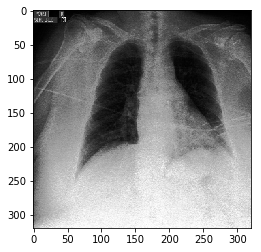

In [103]:
plt.imshow(ans, cmap='gray')

In [42]:
trnsfrm = Compose([
    ToPILImage(),
    Resize(320, 320)
])

In [54]:
new_img = trnsfrm(dataset[0][0])

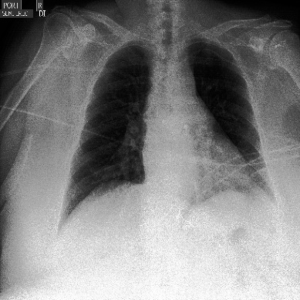

In [77]:
Resize((300, 300))(ToPILImage()(dataset[0][0]))

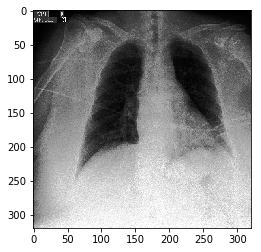

In [63]:
plt.imshow(image.resize((320, 320)), cmap='gray')

In [104]:
import numpy as np
from torch.utils.data import DataLoader
from torch.utils.data.dataloader import default_collate
from torch.utils.data.sampler import SubsetRandomSampler


class BaseDataLoader(DataLoader):
    """
    Base class for all data loaders
    """
    def __init__(self, dataset, batch_size, shuffle, validation_split, num_workers, collate_fn=default_collate):
        self.validation_split = validation_split
        self.shuffle = shuffle

        self.batch_idx = 0
        self.n_samples = len(dataset)

        self.sampler, self.valid_sampler = self._split_sampler(self.validation_split)

        self.init_kwargs = {
            'dataset': dataset,
            'batch_size': batch_size,
            'shuffle': self.shuffle,
            'collate_fn': collate_fn,
            'num_workers': num_workers
        }
        super(BaseDataLoader, self).__init__(sampler=self.sampler, **self.init_kwargs)

    def _split_sampler(self, split):
        if split == 0.0:
            return None, None

        idx_full = np.arange(self.n_samples)

        np.random.seed(0)
        np.random.shuffle(idx_full)

        if isinstance(split, int):
            assert split > 0
            assert split < self.n_samples, "validation set size is configured to be larger than entire dataset."
            len_valid = split
        else:
            len_valid = int(self.n_samples * split)

        valid_idx = idx_full[0:len_valid]
        train_idx = np.delete(idx_full, np.arange(0, len_valid))

        train_sampler = SubsetRandomSampler(train_idx)
        valid_sampler = SubsetRandomSampler(valid_idx)

        # turn off shuffle option which is mutually exclusive with sampler
        self.shuffle = False
        self.n_samples = len(train_idx)

        return train_sampler, valid_sampler

    def split_validation(self):
        if self.valid_sampler is None:
            return None
        else:
            return DataLoader(sampler=self.valid_sampler, **self.init_kwargs)


In [105]:
from torchvision import datasets, transforms
class MnistDataLoader(BaseDataLoader):
    """
    MNIST data loading demo using BaseDataLoader
    """
    def __init__(self, data_dir, batch_size, shuffle=True, validation_split=0.0, num_workers=1, training=True):
        trsfm = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])
        self.data_dir = data_dir
        self.dataset = datasets.MNIST(self.data_dir, train=training, download=True, transform=trsfm)
        super(MnistDataLoader, self).__init__(self.dataset, batch_size, shuffle, validation_split, num_workers)

In [106]:
data_loader = MnistDataLoader("data/",128, True,0.1,2)

In [108]:
i = 0

for batch_idx, (data, target) in enumerate(data_loader):
    print(batch_idx)
    print(data.shape)
    print(target.shape)
    print('--------------------')
    i+=1
    if i == 4:
        break

0
torch.Size([128, 1, 28, 28])
torch.Size([128])
--------------------
1
torch.Size([128, 1, 28, 28])
torch.Size([128])
--------------------
2
torch.Size([128, 1, 28, 28])
torch.Size([128])
--------------------
3
torch.Size([128, 1, 28, 28])
torch.Size([128])
--------------------


In [112]:
class ChexpertDataLoader(BaseDataLoader):
    """
    CheXpert data loader
    """
    def __init__(self, data_dir, batch_size, column_name, shuffle=True, validation_split=0.0, num_workers=1, training=True):
        self.data_dir = data_dir
        self.dataset = ChexpertDataet(data_dir, column_name)
        super(ChexpertDataLoader, self).__init__(self.dataset, batch_size, shuffle, validation_split, num_workers)

In [115]:
data_loader = ChexpertDataLoader(csv_file, 1, "Cardiomegaly", True,0.1, 2)

0
torch.Size([1, 1, 320, 320])
torch.Size([1])
torch.Size([320, 320])
--------------------
1
torch.Size([1, 1, 320, 320])
torch.Size([1])
torch.Size([320, 320])
--------------------
2
torch.Size([1, 1, 320, 320])
torch.Size([1])
torch.Size([320, 320])
--------------------
3
torch.Size([1, 1, 320, 320])
torch.Size([1])
torch.Size([320, 320])
--------------------


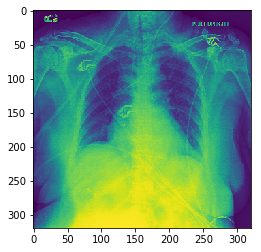

In [122]:
i = 0

for batch_idx, (data, target) in enumerate(data_loader):
    print(batch_idx)
    print(data.shape)
    print(target.shape)
    print(data.squeeze(0).squeeze(0).shape)
    print('--------------------')
    i+=1
    
    plt.imshow(data.squeeze(0).squeeze(0).numpy())
    if i == 4:
        break

In [123]:
import torch.nn.functional as F

In [124]:
help(F.nll_loss)

Help on function nll_loss in module torch.nn.functional:

nll_loss(input, target, weight=None, size_average=None, ignore_index=-100, reduce=None, reduction='mean')
    The negative log likelihood loss.
    
    See :class:`~torch.nn.NLLLoss` for details.
    
    Args:
        input: :math:`(N, C)` where `C = number of classes` or :math:`(N, C, H, W)`
            in case of 2D Loss, or :math:`(N, C, d_1, d_2, ..., d_K)` where :math:`K \geq 1`
            in the case of K-dimensional loss.
        target: :math:`(N)` where each value is :math:`0 \leq \text{targets}[i] \leq C-1`,
            or :math:`(N, d_1, d_2, ..., d_K)` where :math:`K \geq 1` for
            K-dimensional loss.
        weight (Tensor, optional): a manual rescaling weight given to each
            class. If given, has to be a Tensor of size `C`
        size_average (bool, optional): Deprecated (see :attr:`reduction`). By default,
            the losses are averaged over each loss element in the batch. Note that for


In [125]:
# input is of size N x C = 3 x 5
inp = torch.randn(3, 5, requires_grad=True)
# each element in target has to have 0 <= value < C
target = torch.tensor([1, 0, 4])


In [126]:
target

tensor([1, 0, 4])

In [127]:
inp

tensor([[-0.7339,  0.4316, -0.2312, -0.8599, -0.1649],
        [-0.4806,  0.3406,  0.7454, -0.2729, -0.9142],
        [ 0.7692, -0.0028, -0.4379,  0.2944,  1.4104]], requires_grad=True)

In [130]:
F.nll_loss(F.log_softmax(inp), target)

/Users/abkds/anaconda3/envs/ml/lib/python3.5/site-packages/ipykernel/__main__.py:1: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  if __name__ == '__main__':


tensor(1.3120, grad_fn=<NllLossBackward>)

In [132]:
# input = torch.randn(3, 5, requires_grad=True)
# target = torch.randint(5, (3,), dtype=torch.int64)
loss = F.cross_entropy(inp, target)
print(loss)
# >>> loss.backward()

tensor(1.3120, grad_fn=<NllLossBackward>)


In [133]:
from parse_config import ConfigParser

In [134]:
c = ConfigParser()

TypeError: __init__() missing 1 required positional argument: 'args'

In [135]:
help(ConfigParser)


Help on class ConfigParser in module parse_config:

class ConfigParser(builtins.object)
 |  Methods defined here:
 |  
 |  __getitem__(self, name)
 |  
 |  __init__(self, args, options='', timestamp=True)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  get_logger(self, name, verbosity=2)
 |  
 |  initialize(self, name, module, *args)
 |      finds a function handle with the name given as 'type' in config, and returns the 
 |      instance initialized with corresponding keyword args given as 'args'.
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)
 |  
 |  config
 |  
 |  log_dir
 |  
 |  save_dir



In [137]:
help(torch.optim.lr_scheduler)

Help on module torch.optim.lr_scheduler in torch.optim:

NAME
    torch.optim.lr_scheduler

CLASSES
    builtins.object
        ReduceLROnPlateau
    _LRScheduler(builtins.object)
        CosineAnnealingLR
        CosineAnnealingWarmRestarts
        CyclicLR
        ExponentialLR
        LambdaLR
        MultiStepLR
        StepLR
    
    class CosineAnnealingLR(_LRScheduler)
     |  Set the learning rate of each parameter group using a cosine annealing
     |  schedule, where :math:`\eta_{max}` is set to the initial lr and
     |  :math:`T_{cur}` is the number of epochs since the last restart in SGDR:
     |  
     |  .. math::
     |      \eta_{t+1} = \eta_{min} + (\eta_t - \eta_{min})\frac{1 +
     |      \cos(\frac{T_{cur+1}}{T_{max}}\pi)}{1 + \cos(\frac{T_{cur}}{T_{max}}\pi)},
     |      T_{cur} \neq (2k+1)T_{max};\\
     |      \eta_{t+1} = \eta_{t} + (\eta_{max} - \eta_{min})\frac{1 -
     |      \cos(\frac{1}{T_{max}}\pi)}{2},
     |      T_{cur} = (2k+1)T_{max}.\\
     |  
 

In [138]:
import argparse
import collections
import torch
import data_loader.data_loaders as module_data
import model.loss as module_loss
import model.metric as module_metric
import model.model as module_arch

In [139]:
logger = config.get_logger()

<module 'argparse' from '/Users/abkds/anaconda3/envs/ml/lib/python3.5/argparse.py'>

In [140]:
args = argparse.ArgumentParser(description='PyTorch Template')

In [141]:
args

ArgumentParser(prog='__main__.py', usage=None, description='PyTorch Template', formatter_class=<class 'argparse.HelpFormatter'>, conflict_handler='error', add_help=True)

In [142]:
type(False)

bool

In [146]:
bool(1)

True

In [147]:
parser = argparse.ArgumentParser(description="Testing ArgParser")

In [180]:
import dgl

def build_karate_club_graph():
    g = dgl.DGLGraph()
    # add 34 nodes into the graph; nodes are labeled from 0~33
    g.add_nodes(34)
    # all 78 edges as a list of tuples
    edge_list = [(1, 0), (2, 0), (2, 1), (3, 0), (3, 1), (3, 2),
        (4, 0), (5, 0), (6, 0), (6, 4), (6, 5), (7, 0), (7, 1),
        (7, 2), (7, 3), (8, 0), (8, 2), (9, 2), (10, 0), (10, 4),
        (10, 5), (11, 0), (12, 0), (12, 3), (13, 0), (13, 1), (13, 2),
        (13, 3), (16, 5), (16, 6), (17, 0), (17, 1), (19, 0), (19, 1),
        (21, 0), (21, 1), (25, 23), (25, 24), (27, 2), (27, 23),
        (27, 24), (28, 2), (29, 23), (29, 26), (30, 1), (30, 8),
        (31, 0), (31, 24), (31, 25), (31, 28), (32, 2), (32, 8),
        (32, 14), (32, 15), (32, 18), (32, 20), (32, 22), (32, 23),
        (32, 29), (32, 30), (32, 31), (33, 8), (33, 9), (33, 13),
        (33, 14), (33, 15), (33, 18), (33, 19), (33, 20), (33, 22),
        (33, 23), (33, 26), (33, 27), (33, 28), (33, 29), (33, 30),
        (33, 31), (33, 32)]
    # add edges two lists of nodes: src and dst
    src, dst = tuple(zip(*edge_list))
    g.add_edges(src, dst)
    # edges are directional in DGL; make them bi-directional
    g.add_edges(dst, src)

    return g

ImportError: No module named 'dgl'